In [4]:
pip install statsmodels

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install fosforml

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()
 
table_name = '"FACT_CUSTOMER_ORDERS"'
 
sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

In [8]:
df.columns

Index(['ORDER_ID', 'PRODUCT_ID', 'ORDER_QTY', 'ORDER_DATE'], dtype='object')

In [9]:
data = df[['PRODUCT_ID','ORDER_DATE','ORDER_QTY']]

In [10]:
data['ORDER_DATE']=pd.to_datetime(data['ORDER_DATE'])

In [11]:
data_grouped = data.groupby(['PRODUCT_ID',data['ORDER_DATE'].dt.to_period('M')]).agg(Total_Order_Qty=('ORDER_QTY','sum')).reset_index()

In [12]:
New_data_grouped= data.groupby(['PRODUCT_ID',data['ORDER_DATE'].dt.to_period('M')]).agg(Total_Order_Qty=('ORDER_QTY','sum')).reset_index()

In [13]:
New_data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   PRODUCT_ID       2992 non-null   object   
 1   ORDER_DATE       2992 non-null   period[M]
 2   Total_Order_Qty  2992 non-null   int64    
dtypes: int64(1), object(1), period[M](1)
memory usage: 70.2+ KB


In [14]:
data_grouped['ORDER_MONTH']=data_grouped['ORDER_DATE'].dt.to_timestamp()

In [15]:
New_data_grouped['ORDER_MONTH']=New_data_grouped['ORDER_DATE'].dt.to_timestamp()

In [16]:
New_data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PRODUCT_ID       2992 non-null   object        
 1   ORDER_DATE       2992 non-null   period[M]     
 2   Total_Order_Qty  2992 non-null   int64         
 3   ORDER_MONTH      2992 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 93.6+ KB


In [17]:
data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PRODUCT_ID       2992 non-null   object        
 1   ORDER_DATE       2992 non-null   period[M]     
 2   Total_Order_Qty  2992 non-null   int64         
 3   ORDER_MONTH      2992 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 93.6+ KB


In [18]:
data_grouped = data_grouped[['PRODUCT_ID','ORDER_MONTH','Total_Order_Qty']]

In [19]:
New_data_grouped= data_grouped[['PRODUCT_ID','ORDER_MONTH','Total_Order_Qty']]

In [20]:
data_grouped

,PRODUCT_ID,ORDER_MONTH,Total_Order_Qty
0,Product_001,2019-01-01,148400
1,Product_001,2019-02-01,146650
2,Product_001,2019-03-01,133150
3,Product_001,2019-04-01,153600
4,Product_001,2019-05-01,154650
...,...,...,...
2987,Product_100,2024-04-01,30200
2988,Product_100,2024-05-01,27850
2989,Product_100,2024-06-01,33200
2990,Product_100,2024-07-01,33300


In [21]:
data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PRODUCT_ID       2992 non-null   object        
 1   ORDER_MONTH      2992 non-null   datetime64[ns]
 2   Total_Order_Qty  2992 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 70.2+ KB


In [22]:
data_grouped = data_grouped.set_index('ORDER_MONTH')

In [23]:
data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2992 entries, 2019-01-01 to 2024-08-01
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PRODUCT_ID       2992 non-null   object
 1   Total_Order_Qty  2992 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.1+ KB


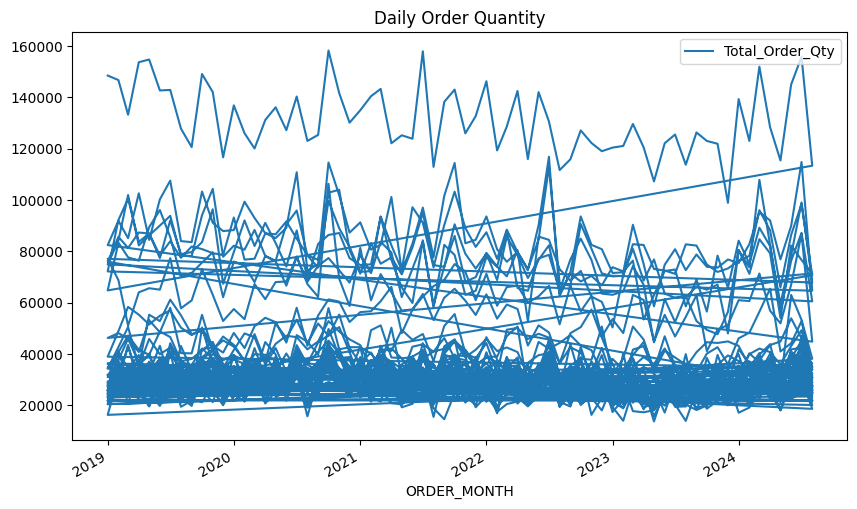

In [27]:
# Plot the data
data_grouped.plot(figsize=(10, 6))
plt.title('Daily Order Quantity')
plt.show()

In [32]:
# Check for stationarity
result = adfuller(data_grouped['Total_Order_Qty'])
print('ADF Statistic:', result)
print('p-value:', result)

ADF Statistic: (-4.851889236785195, 4.322838285686302e-05, 24, 2967, {'1%': -3.432555920657187, '5%': -2.8625146314725565, '10%': -2.5672888226314647}, 60696.178049764596)
p-value: (-4.851889236785195, 4.322838285686302e-05, 24, 2967, {'1%': -3.432555920657187, '5%': -2.8625146314725565, '10%': -2.5672888226314647}, 60696.178049764596)


In [36]:
# Differencing to make the series stationary
data_diff = data_grouped['Total_Order_Qty'].diff().dropna()

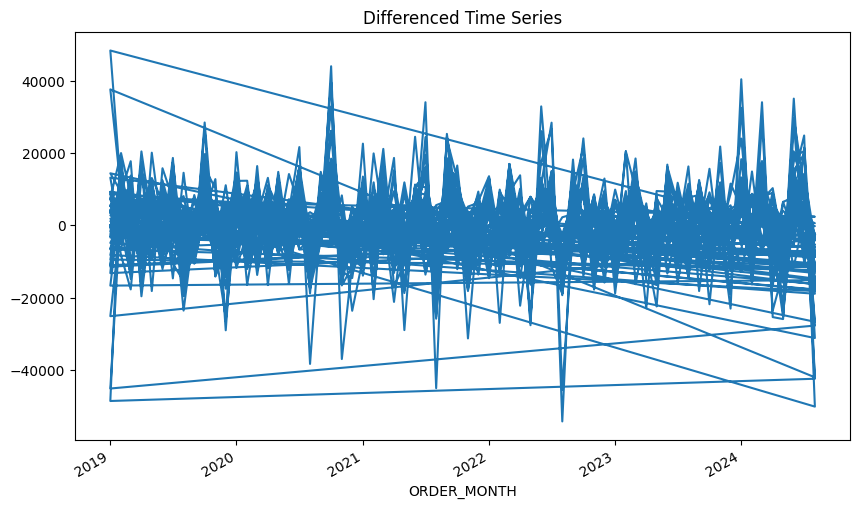

In [40]:
# Plot differenced series
data_diff.plot(figsize=(10, 6))
plt.title('Differenced Time Series')
plt.show()

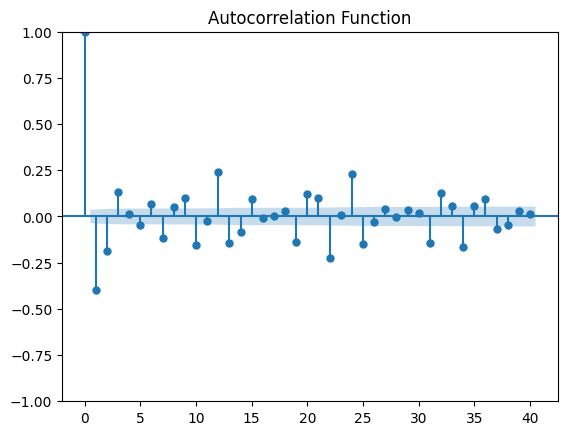

In [41]:
plot_acf(data_diff, lags=40)
plt.title('Autocorrelation Function')
plt.show()

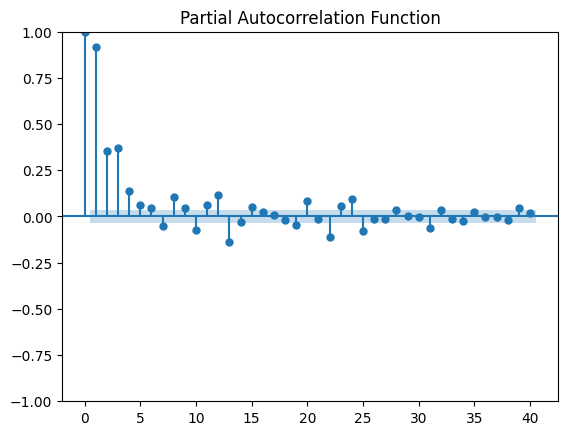

In [42]:
plot_pacf(data_grouped['Total_Order_Qty'], lags=40)
plt.title('Partial Autocorrelation Function')
plt.show()

In [19]:
ORD_grouped_data = data_grouped.groupby('ORDER_MONTH')

In [20]:
print(ORD_grouped_data)

In [21]:
# Group data by 'product_id'
PID_grouped_data = data_grouped.groupby('PRODUCT_ID')

In [22]:
# Initialize an empty DataFrame for forecast results
test_results = pd.DataFrame(columns=['PRODUCT_ID','ORDER_MONTH', 'test_forecast_orders','rse', 'rmse','r2_score'])
test_results.set_index('ORDER_MONTH')

,PRODUCT_ID,test_forecast_orders,rse,rmse,r2_score
ORDER_MONTH,,,,,


In [23]:
# Initialize an empty DataFrame for forecast results
forecast_results = pd.DataFrame(columns=['PRODUCT_ID','ORDER_MONTH', 'forecast_order_qty'])
forecast_results.set_index('ORDER_MONTH')

,PRODUCT_ID,forecast_order_qty
ORDER_MONTH,,


In [24]:
print(PID_grouped_data)

In [27]:
for product_id, group in PID_grouped_data:
    # Sort data by order date
    group.sort_index(inplace=True)
    
    # Split data into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(group))
    train_data, test_data = group.iloc[:train_size], group.iloc[train_size:]

    
    
    # Create SARIMAX model
    model = SARIMAX(train_data['Total_Order_Qty'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Forecast the next period
    test_model = model_fit.get_forecast(steps=len(test_data))
    test_df = test_model.predicted_mean

    #print(f'test_df:{test_df.index}')
    
    # Calculate RMSE for order quantity
    #rmse_order_qty = np.sqrt(mean_squared_error(test_data['ORDER_QTY'], forecast_order_qty))
    
    # Evaluate the model
    residuals=test_df.tolist()-test_data['Total_Order_Qty']
    rse = np.sqrt(((residuals) ** 2).sum().sum() / (test_data.shape[0] * test_data.shape[1] - len(model_fit.params)))
    rmse = np.sqrt(mean_squared_error(test_data['Total_Order_Qty'], test_df))
    r2 = r2_score(test_data['Total_Order_Qty'], test_df)

    
    date_list = test_df.index.to_list()
    #date_list = train_data.index.to_list()

    
    #print(f"Order_date: {date_list}")    
    new_row = {
        'PRODUCT_ID': product_id,
        'ORDER_MONTH': date_list,
        'test_forecast_orders': test_df,
        'rse': rse,
        'rmse': rmse,
        'r2_score': r2
    }
    
    df_new = pd.DataFrame(new_row)

    df_new.set_index('ORDER_MONTH')
    
    test_results=pd.concat([test_results,df_new],ignore_index=True)
    print(f'{test_results}')
    # Forecast future values
    forecast = model_fit.get_forecast(steps=25)#, steps=n_forecast)
    forecast_df = forecast.predicted_mean
    
    date_list2= forecast_df.index.to_list()
    
    new_row2 = {
        'product_id': product_id,
        'order_date': date_list2,
        'forecast_order_qty': forecast_df,
    }
    
    df_new2 = pd.DataFrame(new_row2)
    
    forecast_results=pd.concat([forecast_results,df_new2],ignore_index=True)

      PRODUCT_ID ORDER_MONTH  test_forecast_orders           rse  \
0    Product_001  2023-07-01         118823.028009  12247.075647   
1    Product_001  2023-08-01         101123.262760  12247.075647   
2    Product_001  2023-09-01         105282.149996  12247.075647   
3    Product_001  2023-10-01         117745.845182  12247.075647   
4    Product_001  2023-11-01         110611.593083  12247.075647   
..           ...         ...                   ...           ...   
625  Product_001  2024-04-01         122617.484315  12247.075647   
626  Product_001  2024-05-01         113678.212178  12247.075647   
627  Product_001  2024-06-01         122553.505870  12247.075647   
628  Product_001  2024-07-01         123281.759280  12247.075647   
629  Product_001  2024-08-01         106051.738107  12247.075647   

             rmse  r2_score  
0    15697.565379  -0.05509  
1    15697.565379  -0.05509  
2    15697.565379  -0.05509  
3    15697.565379  -0.05509  
4    15697.565379  -0.05509  
.. 

In [ ]:
# Plot the data
daily_data.plot(figsize=(10, 6))
plt.title('Daily Order Quantity')
plt.show()